In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import numpy as np
import SimpleITK as sitk
import cv2 as cv
import matplotlib.pyplot as plt
import os
import random
import time

from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import StratifiedShuffleSplit

from skimage import io 
from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise

In [2]:
image_size = 256

labels = ['1_Normal', '2_Non_Covid_19','3_Covid_19']

In [3]:
def create_training_data(paths):
    
    images = []
    
    for label in labels:
        dir = os.path.join(paths,label)
        class_num = labels.index(label)
        
        for image in os.listdir(dir):
            image_read = cv.imread(os.path.join(dir,image))
            image_resized = cv.resize(image_read,(image_size,image_size),cv.IMREAD_GRAYSCALE)
            images.append([image_resized,class_num])
            
    return np.array(images)

In [4]:
train = create_training_data('D:/Kaggle datasets/Covid_19_final/train')

In [5]:
test = create_training_data('D:/Kaggle datasets/Covid_19_final/test')

In [6]:
train.shape

(13675, 2)

In [7]:
test.shape

(300, 2)

1_Normal


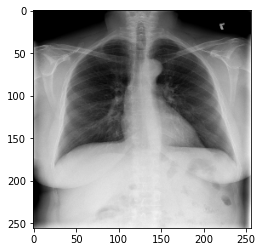

In [8]:
plt.imshow(train[1][0], cmap='gray')
print(labels[train[1][1]])

2_Non_Covid_19


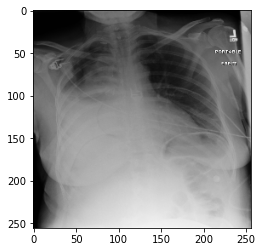

In [9]:
plt.imshow(train[10000][0], cmap='gray')
print(labels[train[10000][1]])

In [10]:
X1 = []
y1 = []
X2 = []
y2 = []

for feature, label in train:
    X1.append(feature)
    y1.append(label)
    
for feature, label in test:
    X2.append(feature)
    y2.append(label)

In [11]:
X1= np.array(X1)
y1 = np.array(y1)
y1 = np.expand_dims(y1, axis=1)

X2= np.array(X2)
y2 = np.array(y2)
y2 = np.expand_dims(y2, axis=1)

In [12]:
print(X1.shape)
print(y1.shape)
print(X2.shape)
print(y2.shape)

(13675, 256, 256, 3)
(13675, 1)
(300, 256, 256, 3)
(300, 1)


In [13]:
#X_training, X_holdout, y_training, y_holdout = train_test_split(X1, y1, test_size=0.2,random_state = 32, stratify=y1)

In [14]:
#print(X_training.shape)
#print(X_holdout.shape)
#print(y_training.shape)
#print(y_holdout.shape)

In [15]:
non_covid_19=0
covid_19=0
normal=0

for i in y1:
    
    if i==0:
        normal += 1
    elif i==1 :
        non_covid_19 += 1
    else:
        covid_19 += 1
        
print ('Number of Normal images =',normal)
print ('Number of Non_Covid_19 images = ',non_covid_19)
print ('Number of Covid_19 images =',covid_19)

Number of Normal images = 7966
Number of Non_Covid_19 images =  5451
Number of Covid_19 images = 258


In [16]:
difference_non_covid = normal - non_covid_19
difference_covid = normal - covid_19

generate_new_covid_images = 2000

print(difference_non_covid)
print(difference_covid)

2515
7708


In [17]:
def rotate_images(image, scale =1.0, h=256, w = 256):
    
    center = (h/2,w/2)
    
    angle = random.randint(-25,25)
    M = cv.getRotationMatrix2D(center, angle, scale)
    rotated = cv.warpAffine(image, M, (h,w))
    return rotated

def flip (image):
    
    flipped = np.fliplr(image)
    return flipped

def translation (image):
    
    x= random.randint(-50,50)
    y = random.randint(-50,50)
    rows,cols,z = image.shape
    M = np.float32([[1,0,x],[0,1,y]])
    translate = cv.warpAffine(image,M,(cols,rows))
    
    return translate

def blur (image):
    
    x = random.randrange(1,5,2)
    blur = cv.GaussianBlur(image,(x,x),cv.BORDER_DEFAULT)
    return blur

In [18]:
def apply_aug (image):
    
    number = random.randint(1,4)
    
    if number == 1:
        image= rotate_images(image, scale =1.0, h=256, w = 256)
            
    if number == 2:
        image= flip(image)
                
    if number ==3:
        image= translation(image)
                
    if number ==4:
        image= blur(image)
    
    return image

In [19]:
def oversample_images (difference_non_covid,difference_covid, X_train, y_train, scale =1.0,h=256,w=256):
    
    new_non_covid_19 = []
    new_covid_19 = []
    label_non_covid_19 = []
    label_covid_19 = []
    non_covid_counter =0
    covid_counter = 0
    
    for i,item in enumerate (X_train):
        
        if y_train[i] == 1 and non_covid_counter < difference_non_covid:
            
            image = apply_aug(item)
            
            non_covid_counter += 1
            label = 1
            
            new_non_covid_19.append(image)
            label_non_covid_19.append(label)
            
        for covid_counter in range (31):
            
            if y_train[i] == 2 and covid_counter < difference_covid:
            
                image = apply_aug(item)
            
                covid_counter += 1
                label =2
            
                new_covid_19.append(image)
                label_covid_19.append(label)
            
    
    new_non_covid_19 = np.array(new_non_covid_19)
    label_non_covid_19 = np.array(label_non_covid_19)
    new_covid_19= np.array(new_covid_19)
    label_covid_19 = np.array(label_covid_19)
    
    return new_non_covid_19, label_non_covid_19, new_covid_19, label_covid_19

In [20]:
#class_weight = sklearn.utils.class_weight.compute_class_weight('balanced', np.unique = y_train, y_train)

In [21]:
n_images,n_labels,v_images,v_labels =oversample_images(difference_non_covid,difference_covid,X1,y1) 

In [22]:
print(n_images.shape)
print(n_labels.shape)
print(v_images.shape)
print(v_labels.shape)

(2515, 256, 256, 3)
(2515,)
(7998, 256, 256, 3)
(7998,)


1


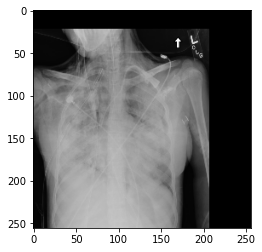

In [23]:
plt.imshow(n_images[1])
plt.show
print(n_labels[1])

In [24]:
new_labels = np.append(n_labels,v_labels)
y_new_labels = np.expand_dims(new_labels, axis=1)
x_new_images = np.append(n_images,v_images,axis=0)

In [25]:
print(x_new_images.shape)
print(y_new_labels.shape)

(10513, 256, 256, 3)
(10513, 1)


In [26]:
X_train1 = np.append(X1,x_new_images,axis=0)
y_train1 = np.append(y1,y_new_labels)

print(X_train1.shape)
print(y_train1.shape)

(24188, 256, 256, 3)
(24188,)


In [27]:
bacteria_new=0
virus_new=0
normal_new =0

for i in y_train1:
    
    if i==0:
        normal_new = normal_new+1
    elif i==1 :
        bacteria_new = bacteria_new+1
    else:
        virus_new=virus_new+1    
        
print ('Number of Normal images =',normal_new)
print ('Number of Bacteria images = ',bacteria_new)
print ('Number of Virus images =',virus_new)

Number of Normal images = 7966
Number of Bacteria images =  7966
Number of Virus images = 8256


In [28]:
def get_train_generator(X_train,y_train, batch_size = 32, shuffle = True, seed = 1):
      
    print("getting train generator...") 
    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True,
        rotation_range = 15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        fill_mode="nearest",
        cval=0.0,
        rescale = 0.2,
        horizontal_flip=True)
    
    generator = image_generator.flow(
            X_train,
            y=y_train,
            shuffle=shuffle,
            batch_size=batch_size,
            seed=seed
            )
    
    return generator

In [29]:
def get_test_val_generator(X_train,y_train,X_test,y_test,
                      batch_size=32,shuffle=False, seed=1, sample_size=100):
    
    raw_train_generator = ImageDataGenerator().flow(
        X_train,y_train, 
        batch_size=sample_size, 
        shuffle=shuffle)
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)
    
    # get test generator
    test_generator = image_generator.flow(
            X_test,
            y=y_test,
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed)
    
    return test_generator

In [30]:
train_generator = get_train_generator(X_train1,y_train1)
test_generator = get_test_val_generator(X_train1,y_train1,X2,y2)

getting train generator...


In [31]:
#from sklearn.utils import class_weight

#class_weights = class_weight.compute_class_weight('balanced',np.unique(train_generator.classes), train_generator.classes)

#class_weights

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


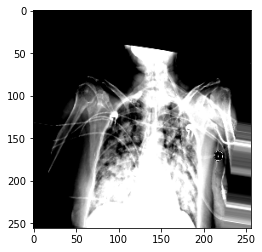

In [32]:
x, y = train_generator.__getitem__(3)
plt.imshow(x[0]);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


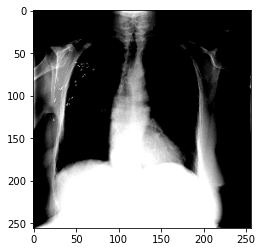

In [33]:
x, y = test_generator.__getitem__(5)
plt.imshow(x[0]);

In [34]:
x_gen,y_gen = train_generator.next()
y_gen

array([0, 0, 0, 2, 1, 0, 2, 1, 1, 1, 0, 1, 2, 2, 0, 0, 0, 1, 1, 2, 2, 2,
       0, 2, 1, 0, 1, 0, 0, 2, 0, 2])

In [35]:
# create the base pre-trained model
base_model = DenseNet121(weights='densenet.hdf5', include_top=False)

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

x = Dense(1024, kernel_regularizer=regularizers.l2(0.003),activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, kernel_regularizer=regularizers.l2(0.003),activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, kernel_regularizer=regularizers.l2(0.003),activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, kernel_regularizer=regularizers.l2(0.003),activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, kernel_regularizer=regularizers.l2(0.003),activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, kernel_regularizer=regularizers.l2(0.003),activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, kernel_regularizer=regularizers.l2(0.003),activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, kernel_regularizer=regularizers.l2(0.003),activation='relu')(x)
x = Dropout(0.5)(x)

# and a logistic layer
out = Dense(3, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=out)

In [36]:
def scheduler(epoch):
    if epoch < 30:
        return 0.0001
    else:
        return 0.0001 * tf.math.exp(0.1 * (10 - epoch))

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)

stopping = EarlyStopping(monitor='val_loss', patience=6)

In [37]:
model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()                   

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [38]:
start_time = time.time()

In [40]:
callbacks = ModelCheckpoint('Trained_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode = 'auto')

batch_size = 32

r = model.fit(train_generator, validation_data=(test_generator), 
                        steps_per_epoch = X_train1.shape[0]//batch_size, epochs= 100, 
                        callbacks = [callbacks,lr_schedule,stopping])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 755 steps, validate for 10 steps
Epoch 1/100
754/755 [============================>.] - ETA: 0s - loss: 18.7989 - accuracy: 0.4781
Epoch 00001: val_loss improved from inf to 13.26445, saving model to Trained_model.h5
755/755 [==============================] - 297s 394ms/step - loss: 18.7910 - accuracy: 0.4784 - val_loss: 13.2645 - val_accuracy: 0.4267
Epoch 2/100
754/755 [============================>.] - ETA: 0s - loss: 8.6802 - accuracy: 0.8635
Epoch 00002: val_loss improved from 13.26445 to 6.19639, saving model to Trained_model.h5
755/755 [==============================] - 261s 346ms/step - loss: 8.6760 - accuracy: 0.8636 - val_loss: 6.1964 - val_accuracy: 0.7833
Epoch 3/100
754/755 [============================>.] - ETA: 0s - loss: 3.5810 - accuracy: 0.9363
Epoch 00003: val_loss improved from 6.19639 to 2.79257, saving model to Trained_model.h5
755/755 [==============================] - 260s 344ms/step - loss: 3.5792 - ac

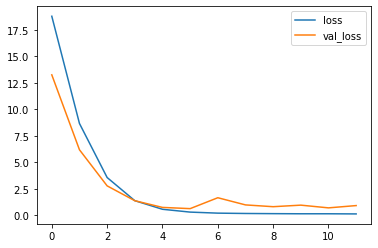

In [41]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

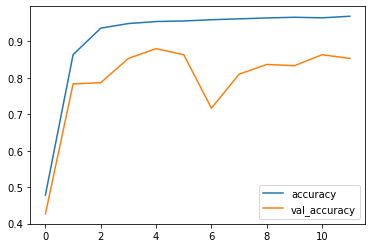

In [42]:
plt.plot(r.history['accuracy'],label='accuracy')
plt.plot(r.history['val_accuracy'],label='val_accuracy')
plt.legend()

In [31]:
final_model = tf.keras.models.load_model('Trained_model.h5')

In [32]:
P= final_model.predict(test_generator, steps=len(test_generator)).argmax(axis=1)
print(P)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 0 2 1 1 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 2 2 0 2 2 0 2 2 2 2 2 2 2 2 0 0 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 1 0 1 2 2 2 0 2 0 2 0 1 2 0 1 1 2 1 2 1 2 2 2 1 1 2 2
 2 2 2 1 2 2 2 2 2 2 1 2 2 0 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 0 0 0 0]


([<matplotlib.axis.YTick at 0x1f6c9000988>,
 [Text(0, 0, '1_Normal'),
  Text(0, 1, '2_Non_Covid_19'),
  Text(0, 2, '3_Covid_19')])

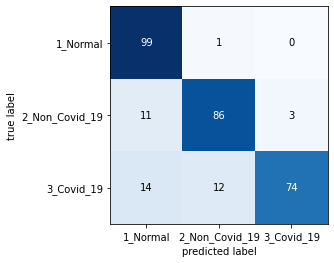

In [33]:
matrix = confusion_matrix (y2, P)
plot_confusion_matrix(matrix, figsize=(4,4))
plt.xticks(range(3), ['1_Normal','2_Non_Covid_19','3_Covid_19'], fontsize=10)
plt.yticks(range(3), ['1_Normal','2_Non_Covid_19', '3_Covid_19'], fontsize=10)

In [42]:
def perf_measure(y_holdout, P):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(P)): 
        if y_holdout[i]==P[i]==1:
           TP += 1
        if y_holdout[i]==1 and y_holdout[i]!=P[i]:
           FN += 1
        if y_holdout[i]==P[i]==0:
           TN += 1
        if y_holdout[i]==0 and y_holdout[i]!=P[i]:
           FP += 1

    return(TP, FP, TN, FN)

In [43]:
TP,FP,TN,FN = perf_measure(y2==0,P==0)
print('TP=',TP)
print('FP=',FP)
print('TN=',TN)
print('FN=',FN)

TP= 99
FP= 25
TN= 175
FN= 1


In [44]:
tp, fp, tn ,fn = perf_measure(y2,P)

precision = tp/(tp+fp)
recall = tp/(tp+fn)
f_score = (2*precision*recall)/(precision+recall)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))
print("F-Score is {:.2f}".format(f_score))

Recall of the model is 0.86
Precision of the model is 0.99
F-Score is 0.92


In [45]:
tp, fp, tn ,fn = perf_measure(y2==0,P==0)

precision = tp/(tp+fp)
recall = tp/(tp+fn)
f_score = (2*precision*recall)/(precision+recall)

print("Recall of the Normal is {:.2f}".format(recall))
print("Precision of the Normal is {:.2f}".format(precision))
print("F-Score of Normal is {:.2f}".format(f_score))

Recall of the Normal is 0.99
Precision of the Normal is 0.80
F-Score of Normal is 0.88


In [46]:
tp, fp, tn ,fn = perf_measure(y2==1,P==1)

precision = tp/(tp+fp)
recall = tp/(tp+fn)
f_score = (2*precision*recall)/(precision+recall)

print("Recall of the Non-Covid-19 is {:.2f}".format(recall))
print("Precision of the Non-Covid-19 is {:.2f}".format(precision))
print("F-Score of Non-Covid-19 {:.2f}".format(f_score))

Recall of the Non-Covid-19 is 0.86
Precision of the Non-Covid-19 is 0.87
F-Score of Non-Covid-19 0.86


In [47]:
tp, fp, tn ,fn = perf_measure(y2==2,P==2)

precision = tp/(tp+fp)
recall = tp/(tp+fn)
f_score = (2*precision*recall)/(precision+recall)

print("Recall of the Covid-19 is {:.2f}".format(recall))
print("Precision of the Covid-19 is {:.2f}".format(precision))
print("F-Score of Covid-19 is {:.2f}".format(f_score))

Recall of the Covid-19 is 0.74
Precision of the Covid-19 is 0.96
F-Score of Covid-19 is 0.84


In [147]:
end_time= time.time()

print("--- %s seconds ---" % (end_time - start_time))

--- 4527.001067876816 seconds ---
